# Importing Packages

In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import pickle

import smote_variants as sv
import imbalanced_databases as imbd
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

from imblearn.under_sampling import CondensedNearestNeighbour, NearMiss, OneSidedSelection, NeighbourhoodCleaningRule, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE, KMeansSMOTE
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier

%reload_ext autoreload
%autoreload 2
from utils import *


# Importing Datasets

In [3]:
pickle_in = open("data/training_cleaned.pickle", "rb")
train = pickle.load(pickle_in)
pickle_in = open("data/validate_cleaned.pickle", "rb")
validate = pickle.load(pickle_in)

In [4]:
X_train = train.drop(["default"], axis=1)
y_train = train["default"]
X_valid = validate.drop(["default"], axis=1)
y_valid = validate["default"]

In [5]:
X_train.head()

,limit,gender,education,marriage,age,behind1,behind2,behind3,behind4,behind5,...,billed3,billed4,billed5,billed6,paid1,paid2,paid3,paid4,paid5,paid6
0,1790.26,2,2,1,44,0,0,0,0,0,...,1278.35,800.60,847.12,981.81,107.99,179.13,107.42,107.42,179.03,33.08
1,5728.83,2,3,1,46,-1,-1,-1,0,-1,...,173.87,147.77,143.04,30.15,83.89,173.87,35.81,143.04,30.15,942.14
2,3580.52,2,2,1,47,-1,-1,-1,-1,-1,...,0.00,224.50,-14.18,-14.18,238.68,0.00,224.50,0.00,0.00,0.00
3,6086.88,2,2,1,29,0,0,0,0,0,...,2267.08,2288.06,1557.71,1575.25,80.02,89.26,92.56,60.26,68.07,75.58
4,5370.78,2,1,2,33,-2,-2,-2,-2,-2,...,1170.90,1198.01,995.38,80.96,966.99,1171.37,1198.58,995.67,80.96,6067.73


In [6]:
X_valid.head()

,limit,gender,education,marriage,age,behind1,behind2,behind3,behind4,behind5,...,billed3,billed4,billed5,billed6,paid1,paid2,paid3,paid4,paid5,paid6
0,1074.16,1,2,2,25,0,0,0,0,0,...,414.66,450.43,491.10,530.92,53.71,71.61,53.71,53.71,53.71,71.61
1,5370.78,2,1,2,26,0,0,0,0,0,...,4177.89,3637.13,2783.53,2766.45,160.62,151.64,113.18,94.78,95.56,95.56
2,2506.36,2,3,1,32,0,0,0,0,0,...,2453.73,2497.52,2510.34,2513.96,87.04,111.43,107.42,87.29,89.51,91.45
3,4654.68,1,3,2,49,0,0,0,0,0,...,579.04,605.04,402.31,248.63,57.65,64.74,251.14,0.97,251.03,157.83
4,1790.26,2,2,2,36,0,0,0,0,0,...,1516.74,700.85,726.67,696.02,71.61,53.71,35.81,64.45,0.00,35.81


In [9]:
training = pd.concat([X_train, y_train], axis=1)
validate = pd.concat([X_valid, y_valid], axis=1)
train = pd.concat([training, validate], axis=0)
train.head()

,limit,gender,education,marriage,age,behind1,behind2,behind3,behind4,behind5,...,billed4,billed5,billed6,paid1,paid2,paid3,paid4,paid5,paid6,default
0,1790.26,2,2,1,44,0,0,0,0,0,...,800.60,847.12,981.81,107.99,179.13,107.42,107.42,179.03,33.08,0
1,5728.83,2,3,1,46,-1,-1,-1,0,-1,...,147.77,143.04,30.15,83.89,173.87,35.81,143.04,30.15,942.14,0
2,3580.52,2,2,1,47,-1,-1,-1,-1,-1,...,224.50,-14.18,-14.18,238.68,0.00,224.50,0.00,0.00,0.00,1
3,6086.88,2,2,1,29,0,0,0,0,0,...,2288.06,1557.71,1575.25,80.02,89.26,92.56,60.26,68.07,75.58,0
4,5370.78,2,1,2,33,-2,-2,-2,-2,-2,...,1198.01,995.38,80.96,966.99,1171.37,1198.58,995.67,80.96,6067.73,0


In [20]:
train_y = train.default
train_X = train.drop(['default'], axis=1)

# Target Variable Visualization

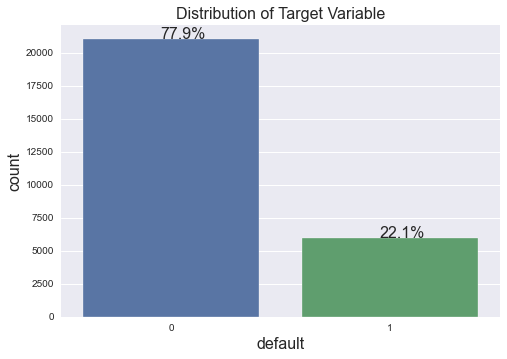

In [18]:
# create visualization for target variable distribution
def barplot(df, xlabel, ylabel, title):
    plt.figure(figsize = (7,5))
    ax = sns.countplot(x = xlabel, data = df)
    plt.title(title, fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    plt.ylabel(ylabel, fontsize = 16)
    total = len(df.default)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 16)
    plt.show()

barplot(train, 'default', 'count', 'Distribution of Target Variable')

# Standardize Datasets

In [24]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_ss = scaler.transform(X_train)
X_valid_ss = scaler.transform(X_valid)

# Using Best Model and 

In [26]:
gbc = GradientBoostingClassifier(random_state=42).fit(X_train_ss, y_train)
y_pred = gbc.predict(X_valid_ss)
get_metric(X_valid_ss, y_valid, y_pred, gbc)

Accuracy Score:  0.8208333333333333
F1 Score:  0.4680851063829787
ROC-AUC Score:  0.7809014124238243
Recall Score:  0.3602437166793602
Precision Score:  0.6680790960451978
PR-AUC Score:  0.5454831454113677


# Running GridSearchCV for Hyperparameters

In [8]:
params = {'n_estimators': range(20, 81, 10)}
gs_gbc = GridSearchCV(estimator = GradientBoostingClassifier(random_state=42),
                      param_grid = params, 
                      n_jobs = 4,
                      iid = False, 
                      cv = 5, 
                      scoring = 'roc_auc',
                      verbose = 1).fit(X_train_ss, y_train)
print("Best: %f using %s" % (gs_gbc.best_score_, gs_gbc.best_params_))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:   30.5s finished
Best: 0.780421 using {'n_estimators': 70}


In [9]:
y_pred_gsgbc = gs_gbc.predict(X_valid_ss)
get_metric(X_valid_ss, y_valid, y_pred_gsgbc, gs_gbc)

Accuracy Score:  0.8213333333333334
F1 Score:  0.46719681908548716
ROC-AUC Score:  0.7803374731131514
Recall Score:  0.357958872810358
Precision Score:  0.6723891273247496
PR-AUC Score:  0.5442969677371212


In [10]:
params_2 = {'max_depth': range(5, 16, 2), 'min_samples_split': range(200, 1001, 200)}
gs_gbc_2 = GridSearchCV(estimator = GradientBoostingClassifier(random_state=42, n_estimators=70),
                        param_grid = params_2, 
                        n_jobs = 4,
                        iid = False, 
                        cv = 5, 
                        scoring = 'roc_auc',
                        verbose = 1).fit(X_train_ss, y_train)
print("Best: %f using %s" % (gs_gbc_2.best_score_, gs_gbc_2.best_params_))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  9.1min finished
Best: 0.781568 using {'max_depth': 5, 'min_samples_split': 1000}


In [11]:
y_pred_gsgbc_2 = gs_gbc_2.predict(X_valid_ss)
get_metric(X_valid_ss, y_valid, y_pred_gsgbc_2, gs_gbc_2)

Accuracy Score:  0.8201666666666667
F1 Score:  0.46504709965294994
ROC-AUC Score:  0.7815831606958106
Recall Score:  0.3571972581873572
Precision Score:  0.6661931818181818
PR-AUC Score:  0.5468047052839891


In [12]:
params_3 = {'min_samples_split': range(1000, 2001, 200), 'min_samples_leaf': range(10, 71, 10)}
gs_gbc_3 = GridSearchCV(estimator = GradientBoostingClassifier(random_state=42, n_estimators=70, max_depth=5),
                        param_grid = params_3, 
                        n_jobs = 4,
                        iid = False, 
                        cv = 5, 
                        scoring = 'roc_auc',
                        verbose = 1).fit(X_train_ss, y_train)
print("Best: %f using %s" % (gs_gbc_3.best_score_, gs_gbc_3.best_params_))

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  6.6min
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:  7.3min finished
Best: 0.783317 using {'min_samples_leaf': 30, 'min_samples_split': 1800}


In [13]:
y_pred_gsgbc_3 = gs_gbc_3.predict(X_valid_ss)
get_metric(X_valid_ss, y_valid, y_pred_gsgbc_3, gs_gbc_3)

Accuracy Score:  0.8205
F1 Score:  0.46603867129400095
ROC-AUC Score:  0.7830263610956786
Recall Score:  0.357958872810358
Precision Score:  0.6676136363636364
PR-AUC Score:  0.5485997794238602


In [14]:
params_4 = {'max_features': range(7, 20, 2)}
gs_gbc_4 = GridSearchCV(estimator = GradientBoostingClassifier(random_state=42, n_estimators=70, min_samples_split=1800, min_samples_leaf=30),
                        param_grid = params_4, 
                        n_jobs = 4,
                        iid = False, 
                        cv = 5, 
                        scoring = 'roc_auc',
                        verbose = 1).fit(X_train_ss, y_train)
print("Best: %f using %s" % (gs_gbc_4.best_score_, gs_gbc_4.best_params_))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:   26.1s finished
Best: 0.781619 using {'max_features': 9}


In [15]:
y_pred_gsgbc_4 = gs_gbc_4.predict(X_valid_ss)
get_metric(X_valid_ss, y_valid, y_pred_gsgbc_4, gs_gbc_4)

Accuracy Score:  0.8201666666666667
F1 Score:  0.46504709965294994
ROC-AUC Score:  0.7804782751338107
Recall Score:  0.3571972581873572
Precision Score:  0.6661931818181818
PR-AUC Score:  0.5437970926408667


In [16]:
params_5 = {'subsample': [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]}
gs_gbc_5 = GridSearchCV(estimator = GradientBoostingClassifier(random_state=42, n_estimators=70, min_samples_split=1800, 
                                                               min_samples_leaf=30, max_features=9),
                        param_grid = params_5, 
                        n_jobs = 4,
                        iid = False, 
                        cv = 5, 
                        scoring = 'roc_auc',
                        verbose = 1).fit(X_train_ss, y_train)
print("Best: %f using %s" % (gs_gbc_5.best_score_, gs_gbc_5.best_params_))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:   15.4s finished
Best: 0.781776 using {'subsample': 0.7}


In [17]:
y_pred_gsgbc_5 = gs_gbc_5.predict(X_valid_ss)
get_metric(X_valid_ss, y_valid, y_pred_gsgbc_5, gs_gbc_5)

Accuracy Score:  0.8195
F1 Score:  0.4672897196261682
ROC-AUC Score:  0.7789054036289385
Recall Score:  0.3617669459253618
Precision Score:  0.6597222222222222
PR-AUC Score:  0.5372269413921732


In [18]:
gbc_tuned = GradientBoostingClassifier(random_state=42, n_estimators=140, min_samples_split=1800, 
                                       min_samples_leaf=30, max_features=9, subsample=0.7, learning_rate=0.05).fit(X_train_ss, y_train)
y_pred_gbc_tuned = gbc_tuned.predict(X_valid_ss)
get_metric(X_valid_ss, y_valid, y_pred_gbc_tuned, gbc_tuned)

Accuracy Score:  0.8191666666666667
F1 Score:  0.4678764100049043
ROC-AUC Score:  0.7805194676464905
Recall Score:  0.3632901751713633
Precision Score:  0.6570247933884298
PR-AUC Score:  0.5413461845711439


In [19]:
gbc_tuned_2 = GradientBoostingClassifier(random_state=42, n_estimators=800, min_samples_split=1800, 
                                       min_samples_leaf=30, max_features=9, subsample=0.7, learning_rate=0.01).fit(X_train_ss, y_train)
y_pred_gbc_tuned_2 = gbc_tuned_2.predict(X_valid_ss)
get_metric(X_valid_ss, y_valid, y_pred_gbc_tuned_2, gbc_tuned_2)

Accuracy Score:  0.82
F1 Score:  0.46745562130177515
ROC-AUC Score:  0.7811059937787119
Recall Score:  0.361005331302361
Precision Score:  0.6629370629370629
PR-AUC Score:  0.5410529462314562


In [20]:
gbc_tuned_3 = GradientBoostingClassifier(random_state=42, n_estimators=1600, min_samples_split=1800, 
                                       min_samples_leaf=30, max_features=9, subsample=0.7, learning_rate=0.005).fit(X_train_ss, y_train)
y_pred_gbc_tuned_3 = gbc_tuned_3.predict(X_valid_ss)
get_metric(X_valid_ss, y_valid, y_pred_gbc_tuned_3, gbc_tuned_3)

Accuracy Score:  0.8201666666666667
F1 Score:  0.46925725528775203
ROC-AUC Score:  0.781126386916153
Recall Score:  0.3632901751713633
Precision Score:  0.6625
PR-AUC Score:  0.5417112302681786


In [21]:
gbc_tuned_4 = GradientBoostingClassifier(random_state=42, n_estimators=1600, min_samples_split=1800, 
                                       min_samples_leaf=30, max_features=9, subsample=0.7, learning_rate=0.005).fit(X_train_ss, y_train)
y_pred_gbc_tuned_4 = gbc_tuned_4.predict(X_valid_ss)
get_metric(X_valid_ss, y_valid, y_pred_gbc_tuned_4, gbc_tuned_4)

Accuracy Score:  0.8201666666666667
F1 Score:  0.46925725528775203
ROC-AUC Score:  0.781126386916153
Recall Score:  0.3632901751713633
Precision Score:  0.6625
PR-AUC Score:  0.5417112302681786


# Dummy Classifier

In [21]:
# separate minority and majority classes
majority = train[train.default==0]
minority = train[train.default==1]

#baseline counts
counter = Counter(y_train)
print("Baseline: ", counter)

Baseline:  Counter({0: 16344, 1: 4656})


In [22]:
dc = DummyClassifier(strategy='most_frequent').fit(X_train_ss, y_train)
y_pred_dc = dc.predict(X_valid_ss)
get_metric(X_valid_ss, y_valid, y_pred_dc, dc)

Accuracy Score:  0.7811666666666667
F1 Score:  0.0
ROC-AUC Score:  0.5
Recall Score:  0.0
Precision Score:  0.0
PR-AUC Score:  0.21883333333333332


# Ensemble Methods

- Bagging and boosting algorithms
- Easy Ensemble Classifier: bag of balanced boosted learners known as EasyEnsemble
- classifier is ensemble of Adaboost learners trained on different balanced bootstrap samples
- balancing achieved by random under-sampling

## Bagging Classifier

Instead of using a single tree, we will check if an ensemble of decsion tree can actually alleviate the issue induced by the class imbalancing. First, we will use a bagging classifier and its counter part which internally uses a random under-sampling to balanced each boostrap sample.

Balancing each bootstrap sample allows to increase significantly the balanced accuracy and the geometric mean.

In [55]:
bc = BaggingClassifier(n_estimators=50, random_state=42).fit(X_train_ss, y_train)
y_pred_bc = bc.predict(X_valid_ss)
get_metric(X_valid_ss, y_valid, y_pred_bc, bc)

Accuracy Score:  0.8118333333333333
F1 Score:  0.457993278924628
ROC-AUC Score:  0.7488929613776726
Recall Score:  0.3632901751713633
Precision Score:  0.6194805194805195
PR-AUC Score:  0.5017609097848447


## Balanced Bagging Classifier

A Bagging classifier with additional balancing.

This implementation of Bagging is similar to the scikit-learn implementation. It includes an additional step to balance the training set at fit time using a given sampler.

This classifier can serves as a basis to implement various methods such as Exactly Balanced Bagging, Roughly Balanced Bagging, Over-Bagging, or SMOTE-Bagging.

In [56]:
bbc = BalancedBaggingClassifier(n_estimators=50, random_state=42).fit(X_train_ss, y_train)
y_pred_bbc = bbc.predict(X_valid_ss)
get_metric(X_valid_ss, y_valid, y_pred_bbc, bbc)

Accuracy Score:  0.783
F1 Score:  0.5244704163623083
ROC-AUC Score:  0.7652801066487965
Recall Score:  0.5468392993145469
Precision Score:  0.503859649122807
PR-AUC Score:  0.5141101768863308


## Balanced Bagging Classifier with Gradient Boosting Classifier

In [57]:
bbc3 = BalancedBaggingClassifier(
        base_estimator=HistGradientBoostingClassifier(random_state=42),
        n_estimators=10,
        random_state=42,
        n_jobs=2).fit(X_train_ss, y_train)
y_pred_bbc3 = bbc3.predict(X_valid_ss)
get_metric(X_valid_ss, y_valid, y_pred_bbc3, bbc3)

Accuracy Score:  0.7618333333333334
F1 Score:  0.5331590983338778
ROC-AUC Score:  0.7816608333627179
Recall Score:  0.6214775323686215
Precision Score:  0.4668192219679634
PR-AUC Score:  0.541759943308943


## Balanced Random Forest Classifier

Random forest is another popular ensemble method and it is usually outperforming bagging. Here, we used a vanilla random forest and its balanced counterpart in which each bootstrap sample is balanced.

Similarly to the previous experiment, the balanced classifier outperform the classifier which learn from imbalanced bootstrap samples. In addition, random forest outsperforms the bagging classifier.

In [58]:
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42).fit(X_train_ss, y_train)
y_pred_brf = brf.predict(X_valid_ss)
get_metric(X_valid_ss, y_valid, y_pred_brf, brf)

Accuracy Score:  0.7426666666666667
F1 Score:  0.5199004975124378
ROC-AUC Score:  0.7718711524202592
Recall Score:  0.6367098248286367
Precision Score:  0.4393063583815029
PR-AUC Score:  0.5237137210202338


## RUSBoostClassifier

Random under-sampling integrated in the learning of AdaBoost.

During learning, the problem of class balancing is alleviated by random under-sampling the sample at each iteration of the boosting algorithm

In [59]:
rbc = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R', random_state=42).fit(X_train_ss, y_train)
y_pred_rbc = rbc.predict(X_valid_ss)
get_metric(X_valid_ss, y_valid, y_pred_rbc, rbc)

Accuracy Score:  0.7511666666666666
F1 Score:  0.5200900032144005
ROC-AUC Score:  0.7648475446418779
Recall Score:  0.6161462300076161
Precision Score:  0.449944382647386
PR-AUC Score:  0.5211050914562826


## Easy Ensemble Classifier

Bag of balanced boosted learners also known as EasyEnsemble.

This algorithm is known as EasyEnsemble. The classifier is an ensemble of AdaBoost learners trained on different balanced boostrap samples. The balancing is achieved by random under-sampling.

In [60]:
eec = EasyEnsembleClassifier(random_state=42).fit(X_train_ss, y_train) 
y_pred_eec = eec.predict(X_valid_ss)
get_metric(X_valid_ss, y_valid, y_pred_eec, eec)

Accuracy Score:  0.759
F1 Score:  0.5271419228253761
ROC-AUC Score:  0.7765765235826728
Recall Score:  0.6138613861386139
Precision Score:  0.46189111747851
PR-AUC Score:  0.5280535859382768


In [61]:
data = {'Accuracy': [accuracy_score(y_valid, y_pred_bc),
                     accuracy_score(y_valid, y_pred_bbc),
                     accuracy_score(y_valid, y_pred_bbc3),
                     accuracy_score(y_valid, y_pred_brf),
                     accuracy_score(y_valid, y_pred_rbc),
                     accuracy_score(y_valid, y_pred_eec)],
        'F1 Score': [f1_score(y_valid, y_pred_bc),
                     f1_score(y_valid, y_pred_bbc),
                     f1_score(y_valid, y_pred_bbc3),
                     f1_score(y_valid, y_pred_brf),
                     f1_score(y_valid, y_pred_rbc),
                     f1_score(y_valid, y_pred_eec)],
        'ROC-AUC Score': [auc(X_valid_ss, y_valid, bc),
                          auc(X_valid_ss, y_valid, bbc),
                          auc(X_valid_ss, y_valid, bbc3),
                          auc(X_valid_ss, y_valid, brf),
                          auc(X_valid_ss, y_valid, rbc),
                          auc(X_valid_ss, y_valid, eec)],
        'PR-AUC Score': [aps(X_valid_ss, y_valid, bc),
                         aps(X_valid_ss, y_valid, bbc),
                         aps(X_valid_ss, y_valid, bbc3),
                         aps(X_valid_ss, y_valid, brf),
                         aps(X_valid_ss, y_valid, rbc),
                         aps(X_valid_ss, y_valid, eec)]}

scores = pd.DataFrame(data=data, index = ['BaggingClassifier',
                                          'BalancedBaggingClassifier',
                                          'BBC with GradientBoostingClassifier',
                                          'BalancedRandomForestClassifier',
                                          'RUBoostClassifier',
                                          'EasyEnsembleClassifier'])

scores

,Accuracy,F1 Score,ROC-AUC Score,PR-AUC Score
BaggingClassifier,0.811833,0.457993,0.748893,0.501761
BalancedBaggingClassifier,0.783000,0.524470,0.765280,0.514110
BBC with GradientBoostingClassifier,0.761833,0.533159,0.781661,0.541760
BalancedRandomForestClassifier,0.742667,0.519900,0.771871,0.523714
RUBoostClassifier,0.751167,0.520090,0.764848,0.521105
EasyEnsembleClassifier,0.759000,0.527142,0.776577,0.528054


# Undersampling Methods

- Methods that select samples to keep
    - Condensed Nearest Neighbors
    - Near Miss
- Methods that select samples to delete
    - TomekLinks
    - Edited Nearest Neighbors
- Methods that use combination of both techniques
    - Neighborhood Cleaning Rule
    - One Sided Selection

## TomekLinks

- Detects Tomek's links, which exists if two samples from different categories are nearest neighbors
- using `sampling_strategy` controls which of the sample will be removed, majority or minority, where `auto` is removing majority class
- setting to `all` removes both samples

In [41]:
tl = TomekLinks()
sampling(X_train_ss, y_train, X_valid_ss, y_valid, tl, gbc)

Training Count:  Counter({0: 15100, 1: 4656})
Accuracy Score:  0.819
F1 Score:  0.4843304843304843
ROC-AUC Score:  0.7827721374819203
Recall Score:  0.38842345773038844
Precision Score:  0.6431273644388399
PR-AUC Score:  0.5455259661067252


In [42]:
X_train_tl, y_train_tl = tl.fit_sample(X_train_ss, y_train)
tlm = gbc.fit(X_train_tl, y_train_tl)
y_pred_tl = tlm.predict(X_valid_ss)

## Edited Nearest Neighbours

- applies nearest-neighbors algorithm and removes samples which do not agree enough with neighborhood or not in the same class as the neighbors
- two selection criteria:  `mode` and `all`, majority vs. all, so that more samples will be excluded with `all`
- `RepeatedEditedNearestNeighbours()` repeat algorithm muliple times resulting in more samples removed
- `AllKNN()` repeats algorithm but increase the number of nearest neighbors at each iteration

In [43]:
enn = EditedNearestNeighbours()
sampling(X_train_ss, y_train, X_valid_ss, y_valid, enn, gbc)

Training Count:  Counter({0: 9974, 1: 4656})
Accuracy Score:  0.791
F1 Score:  0.5399853264856933
ROC-AUC Score:  0.780784090947868
Recall Score:  0.5605483625285606
Precision Score:  0.5208775654635527
PR-AUC Score:  0.5374739636281236


In [44]:
X_train_enn, y_train_enn = enn.fit_sample(X_train_ss, y_train)
ennm = gbc.fit(X_train_enn, y_train_enn)
y_pred_enn = ennm.predict(X_valid_ss)

## Near Miss

In [45]:
ns = NearMiss(version=1, n_neighbors=3)
sampling(X_train_ss, y_train, X_valid_ss, y_valid, ns, gbc)

Training Count:  Counter({0: 4656, 1: 4656})
Accuracy Score:  0.49316666666666664
F1 Score:  0.39386087303169226
ROC-AUC Score:  0.6087854448572001
Recall Score:  0.7524752475247525
Precision Score:  0.26673866090712745
PR-AUC Score:  0.2642847850921968


In [46]:
X_train_ns, y_train_ns = ns.fit_sample(X_train_ss, y_train)
nsm = gbc.fit(X_train_ns, y_train_ns)
y_pred_ns = nsm.predict(X_valid_ss)

## Neighborhood Cleaning Rule

In [47]:
ncr = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)
sampling(X_train_ss, y_train, X_valid_ss, y_valid, ncr, gbc)

Training Count:  Counter({0: 10218, 1: 4656})
Accuracy Score:  0.7936666666666666
F1 Score:  0.5411415863602669
ROC-AUC Score:  0.7786266432522033
Recall Score:  0.555978674790556
Precision Score:  0.5270758122743683
PR-AUC Score:  0.5377045139607715


In [48]:
X_train_ncr, y_train_ncr = ncr.fit_sample(X_train_ss, y_train)
ncrm = gbc.fit(X_train_ncr, y_train_ncr)
y_pred_ncr = ncrm.predict(X_valid_ss)

## One Sided Selection

In [49]:
oss = OneSidedSelection(n_neighbors=1, n_seeds_S=200)
sampling(X_train_ss, y_train, X_valid_ss, y_valid, oss, gbc)

Training Count:  Counter({0: 13593, 1: 4656})
Accuracy Score:  0.8186666666666667
F1 Score:  0.48387096774193544
ROC-AUC Score:  0.7795077730352674
Recall Score:  0.38842345773038844
Precision Score:  0.6415094339622641
PR-AUC Score:  0.5419495006583693


In [50]:
X_train_oss, y_train_oss = oss.fit_sample(X_train_ss, y_train)
ossm = gbc.fit(X_train_oss, y_train_oss)
y_pred_oss = ossm.predict(X_valid_ss)

In [51]:
data = {'Accuracy': [accuracy_score(y_valid, y_pred_tl),
                     accuracy_score(y_valid, y_pred_enn),
                     accuracy_score(y_valid, y_pred_ns),
                     accuracy_score(y_valid, y_pred_ncr),
                     accuracy_score(y_valid, y_pred_oss)],
        'F1 Score': [f1_score(y_valid, y_pred_tl),
                     f1_score(y_valid, y_pred_enn),
                     f1_score(y_valid, y_pred_ns),
                     f1_score(y_valid, y_pred_ncr),
                     f1_score(y_valid, y_pred_oss)],
        'ROC-AUC Score': [auc(X_valid_ss, y_valid, tlm),
                          auc(X_valid_ss, y_valid, ennm),
                          auc(X_valid_ss, y_valid, nsm),
                          auc(X_valid_ss, y_valid, ncrm),
                          auc(X_valid_ss, y_valid, ossm)],
        'PR-AUC Score': [aps(X_valid_ss, y_valid, tlm),
                         aps(X_valid_ss, y_valid, ennm),
                         aps(X_valid_ss, y_valid, nsm),
                         aps(X_valid_ss, y_valid, ncrm),
                         aps(X_valid_ss, y_valid, ossm)]}

scores2 = pd.DataFrame(data=data, index = ['TomekLinks',
                                           'EditedNearestNeighbour',
                                           'NearMiss',                                                                'NeighborhoodCleaningRule',
                                           'OenSidedSelection'])

scores2

,Accuracy,F1 Score,ROC-AUC Score,PR-AUC Score
TomekLinks,0.819000,0.484330,0.781221,0.542721
EditedNearestNeighbour,0.791000,0.539985,0.781221,0.542721
NearMiss,0.493167,0.393861,0.781221,0.542721
NeighborhoodCleaningRule,0.793667,0.541142,0.781221,0.542721
OenSidedSelection,0.819500,0.486486,0.781221,0.542721


# Oversampling Methods

## SMOTE

In [32]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
sampling(X_train_ss, y_train, X_valid_ss, y_valid, sm, gbc)

Training Count:  Counter({0: 16344, 1: 16344})
Accuracy Score:  0.7935
F1 Score:  0.516582130316036
ROC-AUC Score:  0.7640743928654243
Recall Score:  0.5041888804265042
Precision Score:  0.5296
PR-AUC Score:  0.5268566190077079


In [33]:
X_train_sm, y_train_sm = sm.fit_sample(X_train_ss, y_train)
smm = gbc.fit(X_train_sm, y_train_sm)
y_pred_sm = smm.predict(X_valid_ss)

## SVMSMOTE

- Variant of SMOTE algorithm which uses an SVM algorithm to detect sample for generating new synthetic samples

In [34]:
svmsm = SVMSMOTE()
sampling(X_train_ss, y_train, X_valid_ss, y_valid, svmsm, gbc)

Training Count:  Counter({0: 16344, 1: 16344})
Accuracy Score:  0.7883333333333333
F1 Score:  0.5261194029850748
ROC-AUC Score:  0.7729490637924964
Recall Score:  0.536938309215537
Precision Score:  0.5157278712509145
PR-AUC Score:  0.5236224852867296


In [35]:
X_train_svm, y_train_svm = svmsm.fit_sample(X_train_ss, y_train)
svmsmote = gbc.fit(X_train_svm, y_train_svm)
y_pred_svmsm = svmsmote.predict(X_valid_ss)

## KMeans SMOTE

In [36]:
ksm = KMeansSMOTE(random_state=42)
sampling(X_train_ss, y_train, X_valid_ss, y_valid, ksm, gbc)

Training Count:  Counter({0: 16344, 1: 16344})
Accuracy Score:  0.8168333333333333
F1 Score:  0.5073957866427612
ROC-AUC Score:  0.7745015421599274
Recall Score:  0.43107387661843105
Precision Score:  0.616557734204793
PR-AUC Score:  0.5282471598003755


In [37]:
X_train_ksm, y_train_ksm = ksm.fit_sample(X_train_ss, y_train)
kms_smote = gbc.fit(X_train_ksm, y_train_ksm)
y_pred_ksm = kms_smote.predict(X_valid_ss)

## ADASYN

- Oversample using Adaptive Synthetic (ADASYN) algorithm

In [38]:
adsn = ADASYN()
sampling(X_train_ss, y_train, X_valid_ss, y_valid, adsn, gbc)

Training Count:  Counter({0: 16344, 1: 15923})
Accuracy Score:  0.79
F1 Score:  0.5074276778733385
ROC-AUC Score:  0.7601663852522029
Recall Score:  0.49428789032749426
Precision Score:  0.521285140562249
PR-AUC Score:  0.5193548854833809


In [39]:
X_train_adsn, y_train_adsn = adsn.fit_sample(X_train_ss, y_train)
adsnm = gbc.fit(X_train_adsn, y_train_adsn)
y_pred_adsnm = adsnm.predict(X_valid_ss)

In [40]:
data = {'Accuracy': [accuracy_score(y_valid, y_pred_sm),
                     accuracy_score(y_valid, y_pred_svmsm),
                     accuracy_score(y_valid, y_pred_ksm),
                     accuracy_score(y_valid, y_pred_adsnm)],
        'F1 Score': [f1_score(y_valid, y_pred_sm),
                     f1_score(y_valid, y_pred_svmsm),
                     f1_score(y_valid, y_pred_ksm),
                     f1_score(y_valid, y_pred_adsnm)],
        'ROC-AUC Score': [auc(X_valid_ss, y_valid, smm),
                          auc(X_valid_ss, y_valid, svmsmote),
                          auc(X_valid_ss, y_valid, kms_smote),
                          auc(X_valid_ss, y_valid, adsnm)],
        'PR-AUC Score': [aps(X_valid_ss, y_valid, smm),
                         aps(X_valid_ss, y_valid, svmsmote),
                         aps(X_valid_ss, y_valid, kms_smote),
                         aps(X_valid_ss, y_valid, adsnm)]}

scores3 = pd.DataFrame(data=data, index = ['SMOTE',
                                           'SVMSMOTE',
                                           'KMeans-SMOTE',
                                           'ADASYN'])

scores3

,Accuracy,F1 Score,ROC-AUC Score,PR-AUC Score
SMOTE,0.793500,0.516582,0.76088,0.522925
SVMSMOTE,0.797000,0.529002,0.76088,0.522925
KMeans-SMOTE,0.816833,0.507396,0.76088,0.522925
ADASYN,0.788833,0.508343,0.76088,0.522925


# Combined Methods

## SMOTE-Tomek

- oversampling using SMOTE and cleaning using Tomek Links

In [29]:
smtk = SMOTETomek()
sampling(X_train_ss, y_train, X_valid_ss, y_valid, smtk, gbc)

Training Count:  Counter({0: 15934, 1: 15934})
Accuracy Score:  0.7956666666666666
F1 Score:  0.5233281493001555
ROC-AUC Score:  0.7677168834541133
Recall Score:  0.5125666412795126
Precision Score:  0.534551231135822
PR-AUC Score:  0.5300901766231029


In [30]:
X_train_smt, y_train_smt = smtk.fit_sample(X_train_ss, y_train)
smtkm = gbc.fit(X_train_smt, y_train_smt)
y_pred_smtk = smtkm.predict(X_valid_ss)

## SMOTE-ENN

- Oversampling using SMOTE and cleaning using ENN

In [27]:
smenn = SMOTEENN(sampling_strategy="minority", n_jobs= -1)
sampling(X_train_ss, y_train, X_valid_ss, y_valid, smenn, gbc)

Training Count:  Counter({1: 12456, 0: 8496})
Accuracy Score:  0.7278333333333333
F1 Score:  0.5123917587339505
ROC-AUC Score:  0.7718542529278778
Recall Score:  0.6534653465346535
Precision Score:  0.4214145383104126
PR-AUC Score:  0.5307484484173421


In [28]:
X_train_sme, y_train_sme = smenn.fit_sample(X_train_ss, y_train)
smennm = gbc.fit(X_train_sme, y_train_sme)
y_pred_smenn = smennm.predict(X_valid_ss)

In [31]:
data = {'Accuracy': [accuracy_score(y_valid, y_pred_smtk),
                     accuracy_score(y_valid, y_pred_smenn)],
        'F1 Score': [f1_score(y_valid, y_pred_smtk),
                     f1_score(y_valid, y_pred_smenn)],
        'ROC-AUC Score': [auc(X_valid_ss, y_valid, smtkm),
                          auc(X_valid_ss, y_valid, smennm)],
        'PR-AUC Score': [aps(X_valid_ss, y_valid, smtkm),
                         aps(X_valid_ss, y_valid, smennm)]}

scores4 = pd.DataFrame(data=data, index = ['SMOTE-Tomek',
                                           'SMOTE-ENN'])

scores4

,Accuracy,F1 Score,ROC-AUC Score,PR-AUC Score
SMOTE-Tomek,0.794000,0.516810,0.765443,0.529162
SMOTE-ENN,0.730833,0.517766,0.765443,0.529162


In [80]:
scores_comb = pd.concat([scores, scores2, scores3, scores4], axis=0)
scores_comb

,Accuracy,F1 Score,ROC-AUC Score,PR-AUC Score
BaggingClassifier,0.811833,0.457993,0.748893,0.501761
BalancedBaggingClassifier,0.783000,0.524470,0.765280,0.514110
BBC with GradientBoostingClassifier,0.761833,0.533159,0.781661,0.541760
BalancedRandomForestClassifier,0.742667,0.519900,0.771871,0.523714
RUBoostClassifier,0.751167,0.520090,0.764848,0.521105
EasyEnsembleClassifier,0.759000,0.527142,0.776577,0.528054
TomekLinks,0.819000,0.484330,0.780808,0.544681
EditedNearestNeighbour,0.791000,0.539985,0.780808,0.544681
NearMiss,0.493167,0.393861,0.780808,0.544681
NeighborhoodCleaningRule,0.793667,0.541142,0.780808,0.544681


In [82]:
scores_comb.to_csv('data/imbalanced_scores.csv')